# GoEmotions - Evaluation Pipeline

**Task**: Multi-label Emotion Classification  
**Objective**: Comprehensive evaluation for multi-label models  

---

## Pipeline Overview

1. Environment Setup
2. Load Models & Data
3. Multi-label Metrics
4. Threshold Optimization
5. Per-Label Performance
6. Label Correlation Analysis
7. Inference Speed Benchmarking
8. Generate Report

## 1. Environment Setup

In [16]:
!pip install -q transformers datasets accelerate scikit-learn
!pip install -q matplotlib seaborn pandas numpy

In [17]:
import os
import json
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    hamming_loss, jaccard_score, accuracy_score,
    multilabel_confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [18]:
class EvalConfig:
    DATA_DIR = './processed_data'
    MODEL_DIR = './models'
    LOG_DIR = './logs'
    EVAL_DIR = './evaluation'
    
    MODELS = {
        'bert-base': 'go_emotions_bert-base_best',
        'distilbert': 'go_emotions_distilbert_best',
        'tinybert': 'go_emotions_tinybert_best'
    }
    
    BATCH_SIZE = 32
    DEFAULT_THRESHOLD = 0.5

config = EvalConfig()
os.makedirs(config.EVAL_DIR, exist_ok=True)

config_path = os.path.join(config.DATA_DIR, 'go_emotions_config.json')
with open(config_path, 'r') as f:
    data_config = json.load(f)

LABEL_NAMES = data_config['label_names']
NUM_LABELS = data_config['num_labels']

print(f"📋 Configuration loaded!")
print(f"   Number of labels: {NUM_LABELS}")

📋 Configuration loaded!
   Number of labels: 28


## 2. Load Models & Data

In [19]:
print("📥 Loading test dataset...")

dataset_path = os.path.join(config.DATA_DIR, 'go_emotions_tokenized')
dataset = load_from_disk(dataset_path)
test_dataset = dataset['test']

print(f"✅ Test dataset loaded: {len(test_dataset):,} samples")

📥 Loading test dataset...
✅ Test dataset loaded: 5,427 samples


In [20]:
def load_model(model_name):
    model_path = os.path.join(config.MODEL_DIR, config.MODELS[model_name])
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()
    return model, tokenizer

print("📦 Loading models...")
models = {}
tokenizers = {}

for model_name in config.MODELS.keys():
    models[model_name], tokenizers[model_name] = load_model(model_name)
    print(f"   ✅ {model_name} loaded")

print("\n✅ All models loaded!")

📦 Loading models...
   ✅ bert-base loaded
   ✅ distilbert loaded
   ✅ tinybert loaded

✅ All models loaded!


## 3. Multi-label Metrics Computation

In [21]:
@torch.no_grad()
def get_predictions(model, dataset, batch_size=32):
    """Get predictions and probabilities for multi-label classification."""
    model.eval()
    
    all_logits = []
    all_labels = []
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        all_logits.extend(outputs.logits.cpu().numpy())
        all_labels.extend(labels.numpy())
    
    logits = np.array(all_logits)
    labels = np.array(all_labels)
    
    probs = 1 / (1 + np.exp(-logits))
    
    return {
        'logits': logits,
        'probabilities': probs,
        'labels': labels
    }

print("🔄 Getting predictions...")
results = {}

for model_name, model in models.items():
    print(f"   Processing {model_name}...")
    results[model_name] = get_predictions(model, test_dataset, config.BATCH_SIZE)

print("\n✅ All predictions obtained!")

🔄 Getting predictions...
   Processing bert-base...
   Processing distilbert...
   Processing tinybert...

✅ All predictions obtained!


In [22]:
def compute_multilabel_metrics(y_true, y_prob, threshold=0.5):
    """Compute comprehensive multi-label metrics."""
    y_pred = (y_prob > threshold).astype(int)
    y_true = y_true.astype(int)
    
    metrics = {
        'f1_micro': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_samples': f1_score(y_true, y_pred, average='samples', zero_division=0),
        
        'precision_micro': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_micro': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        
        'hamming_loss': hamming_loss(y_true, y_pred),
        'exact_match': accuracy_score(y_true, y_pred),
        'jaccard_micro': jaccard_score(y_true, y_pred, average='micro', zero_division=0),
        'jaccard_samples': jaccard_score(y_true, y_pred, average='samples', zero_division=0),
    }
    
    return metrics

all_metrics = {}
true_labels = results['bert-base']['labels']

for model_name in results.keys():
    probs = results[model_name]['probabilities']
    all_metrics[model_name] = compute_multilabel_metrics(true_labels, probs)

print("\n📊 Multi-label Metrics Comparison:")
print("="*80)

metrics_df = pd.DataFrame(all_metrics).T
print(metrics_df.round(4).to_string())


📊 Multi-label Metrics Comparison:
            f1_micro  f1_macro  f1_weighted  f1_samples  precision_micro  precision_macro  recall_micro  recall_macro  hamming_loss  exact_match  jaccard_micro  jaccard_samples
bert-base     0.5316    0.4759       0.5618      0.5700           0.4143            0.407        0.7418        0.6562        0.0544       0.2535         0.3621           0.4819
distilbert    0.5310    0.4699       0.5613      0.5658           0.4131            0.392        0.7429        0.6533        0.0547       0.2464         0.3614           0.4768
tinybert      0.4140    0.2914       0.4325      0.4586           0.2915            0.214        0.7143        0.5127        0.0842       0.1255         0.2610           0.3582


## 4. Threshold Optimization

In [23]:
def find_optimal_threshold(y_true, y_prob, metric='f1_micro', thresholds=None):
    """Find optimal threshold for multi-label classification."""
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.05)
    
    best_threshold = 0.5
    best_score = 0
    scores = []
    
    for thresh in thresholds:
        y_pred = (y_prob > thresh).astype(int)
        
        if metric == 'f1_micro':
            score = f1_score(y_true, y_pred, average='micro', zero_division=0)
        elif metric == 'f1_macro':
            score = f1_score(y_true, y_pred, average='macro', zero_division=0)
        elif metric == 'jaccard':
            score = jaccard_score(y_true, y_pred, average='micro', zero_division=0)
        else:
            score = f1_score(y_true, y_pred, average='micro', zero_division=0)
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            best_threshold = thresh
    
    return best_threshold, best_score, thresholds, scores

print("🎯 Finding optimal thresholds...")

optimal_thresholds = {}
threshold_curves = {}

for model_name, res in results.items():
    probs = res['probabilities']
    
    best_thresh, best_score, thresholds, scores = find_optimal_threshold(
        true_labels, probs, metric='f1_micro'
    )
    
    optimal_thresholds[model_name] = {
        'threshold': best_thresh,
        'f1_micro': best_score
    }
    threshold_curves[model_name] = {'thresholds': thresholds, 'scores': scores}
    
    print(f"   {model_name}: optimal threshold = {best_thresh:.2f}, F1 = {best_score:.4f}")

🎯 Finding optimal thresholds...
   bert-base: optimal threshold = 0.75, F1 = 0.5682
   distilbert: optimal threshold = 0.70, F1 = 0.5668
   tinybert: optimal threshold = 0.60, F1 = 0.4553


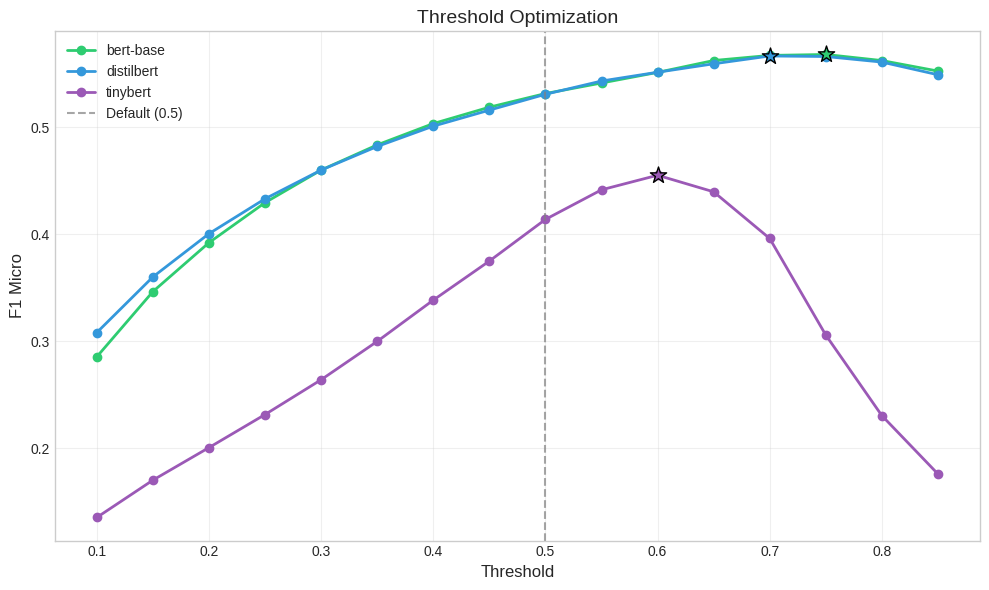

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71', '#3498db', '#9b59b6']

for (model_name, data), color in zip(threshold_curves.items(), colors):
    ax.plot(data['thresholds'], data['scores'], 'o-', label=model_name, color=color, linewidth=2)
    
    opt_thresh = optimal_thresholds[model_name]['threshold']
    opt_score = optimal_thresholds[model_name]['f1_micro']
    ax.scatter([opt_thresh], [opt_score], s=150, marker='*', color=color, edgecolor='black', zorder=5)

ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default (0.5)')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('F1 Micro', fontsize=12)
ax.set_title('Threshold Optimization', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'threshold_optimization.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Per-Label Performance Analysis

In [25]:
def compute_per_label_metrics(y_true, y_prob, label_names, threshold=0.5):
    """Compute metrics for each label."""
    y_pred = (y_prob > threshold).astype(int)
    
    per_label = []
    
    for i, label in enumerate(label_names):
        true_i = y_true[:, i]
        pred_i = y_pred[:, i]
        
        per_label.append({
            'label': label,
            'support': true_i.sum(),
            'precision': precision_score(true_i, pred_i, zero_division=0),
            'recall': recall_score(true_i, pred_i, zero_division=0),
            'f1': f1_score(true_i, pred_i, zero_division=0),
            'predicted_positive': pred_i.sum()
        })
    
    return pd.DataFrame(per_label)

best_model = 'bert-base'
probs = results[best_model]['probabilities']
opt_thresh = optimal_thresholds[best_model]['threshold']

per_label_df = compute_per_label_metrics(true_labels, probs, LABEL_NAMES, opt_thresh)
per_label_df = per_label_df.sort_values('f1', ascending=False)

print(f"\n📊 Per-Label Performance ({best_model}, threshold={opt_thresh:.2f}):")
print("="*80)
print(per_label_df.round(4).to_string(index=False))


📊 Per-Label Performance (bert-base, threshold=0.75):
         label  support  precision  recall     f1  predicted_positive
     gratitude      352     0.8723  0.9318 0.9011                 376
     amusement      264     0.7470  0.9280 0.8277                 328
          love      238     0.7326  0.8866 0.8023                 288
    admiration      504     0.6196  0.8016 0.6990                 652
       remorse       56     0.5568  0.8750 0.6806                  88
          fear       78     0.5446  0.7821 0.6421                 112
           joy      161     0.5495  0.6894 0.6116                 202
       neutral     1787     0.7571  0.4745 0.5834                1120
     curiosity      284     0.4538  0.7782 0.5733                 487
      surprise      141     0.5449  0.6028 0.5724                 156
      optimism      186     0.5288  0.5914 0.5584                 208
       sadness      156     0.4575  0.6218 0.5272                 212
         anger      198     0.4307  

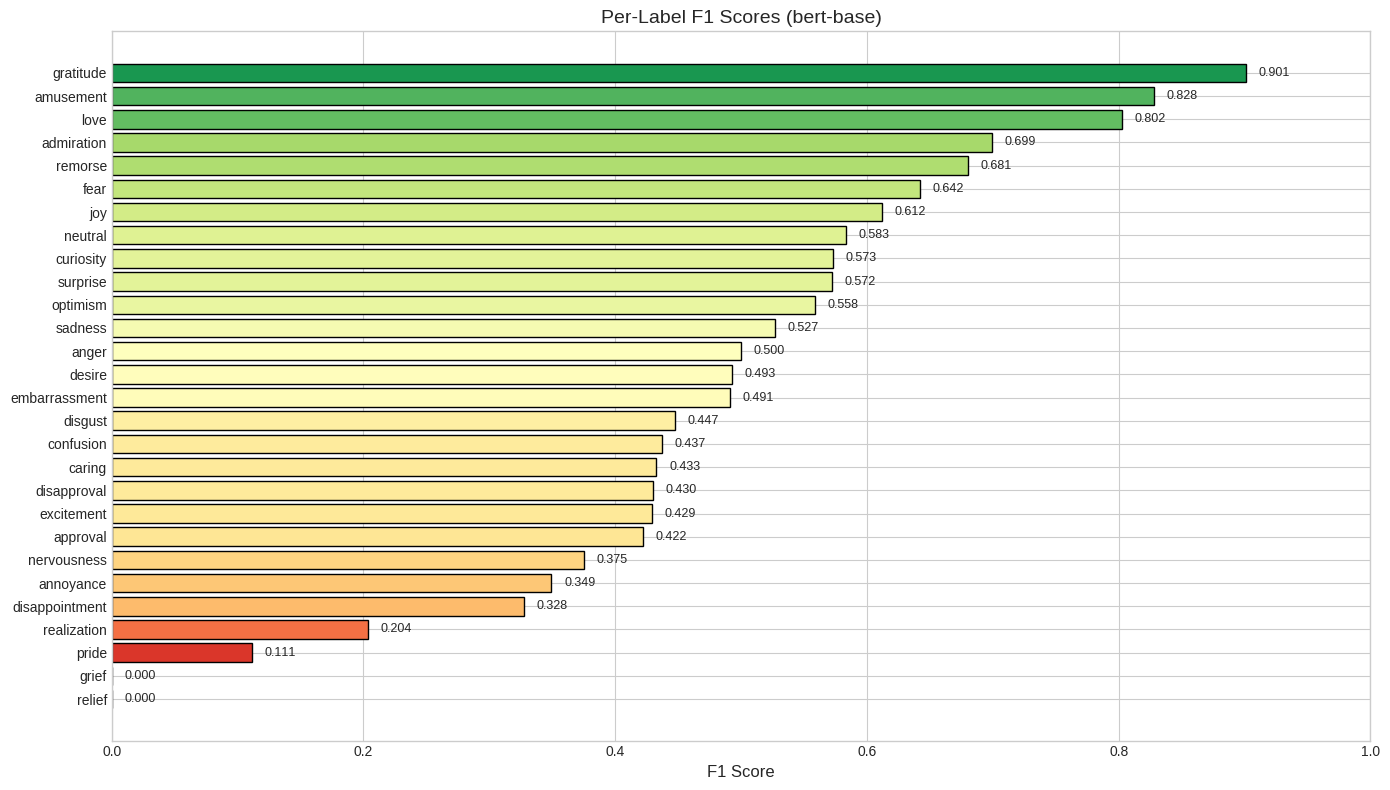

In [26]:
fig, ax = plt.subplots(figsize=(14, 8))

sorted_df = per_label_df.sort_values('f1', ascending=True)

colors = plt.cm.RdYlGn(sorted_df['f1'].values)
bars = ax.barh(range(len(sorted_df)), sorted_df['f1'].values, color=colors, edgecolor='black')
ax.set_yticks(range(len(sorted_df)))
ax.set_yticklabels(sorted_df['label'].values)
ax.set_xlabel('F1 Score', fontsize=12)
ax.set_title(f'Per-Label F1 Scores ({best_model})', fontsize=14)

for bar, f1 in zip(bars, sorted_df['f1'].values):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
           f'{f1:.3f}', va='center', fontsize=9)

ax.set_xlim(0, 1.0)

plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'per_label_f1.png'), dpi=150, bbox_inches='tight')
plt.show()

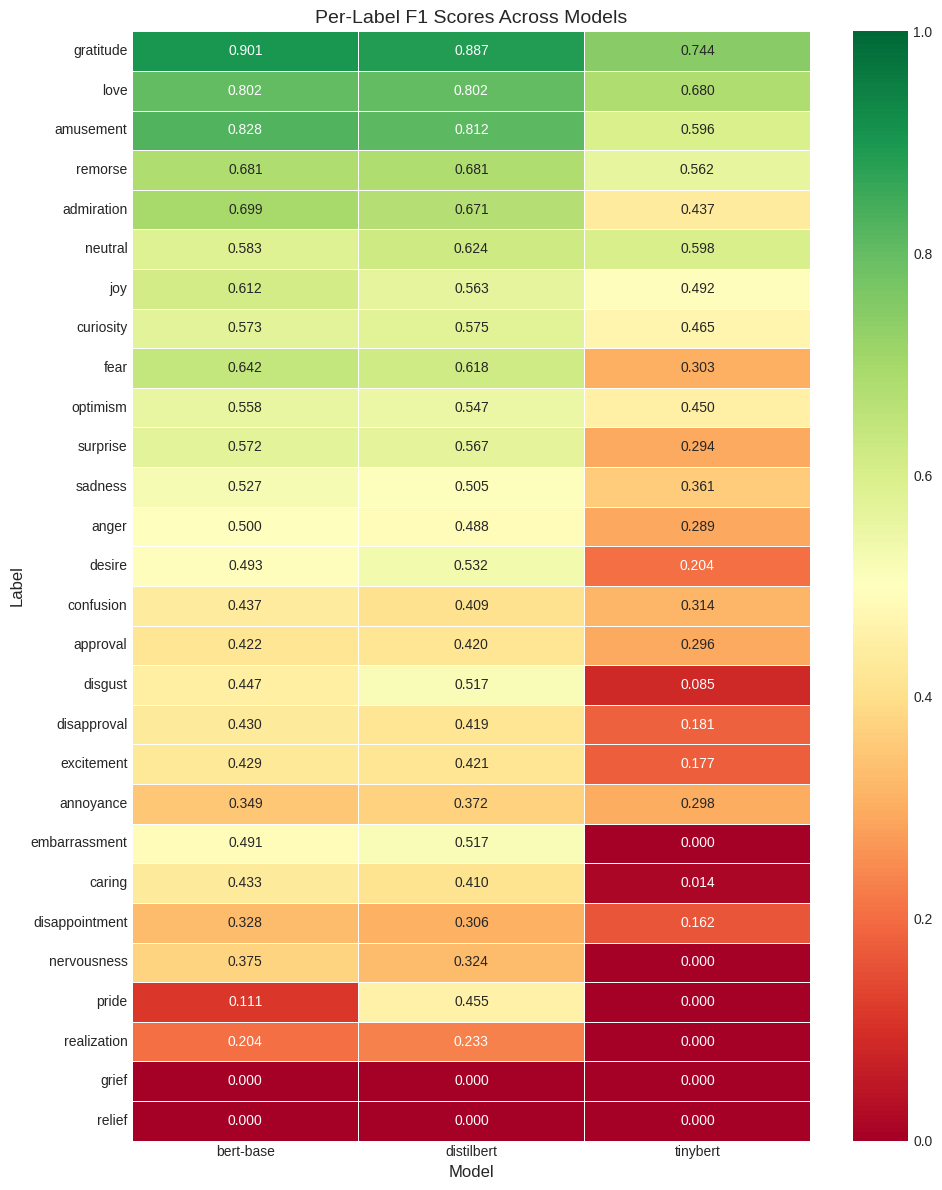

In [27]:
def compare_models_per_label(results, true_labels, label_names, optimal_thresholds):
    """Compare per-label F1 across models."""
    comparison = []
    
    for model_name, res in results.items():
        probs = res['probabilities']
        thresh = optimal_thresholds[model_name]['threshold']
        y_pred = (probs > thresh).astype(int)
        
        for i, label in enumerate(label_names):
            f1 = f1_score(true_labels[:, i], y_pred[:, i], zero_division=0)
            comparison.append({
                'model': model_name,
                'label': label,
                'f1': f1
            })
    
    return pd.DataFrame(comparison)

comparison_df = compare_models_per_label(results, true_labels, LABEL_NAMES, optimal_thresholds)

pivot_df = comparison_df.pivot(index='label', columns='model', values='f1')

pivot_df['mean'] = pivot_df.mean(axis=1)
pivot_df = pivot_df.sort_values('mean', ascending=False)
pivot_df = pivot_df.drop('mean', axis=1)

fig, ax = plt.subplots(figsize=(10, 12))

sns.heatmap(
    pivot_df,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    ax=ax,
    vmin=0,
    vmax=1,
    linewidths=0.5
)

ax.set_title('Per-Label F1 Scores Across Models', fontsize=14)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Label', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'per_label_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. Label Correlation Analysis

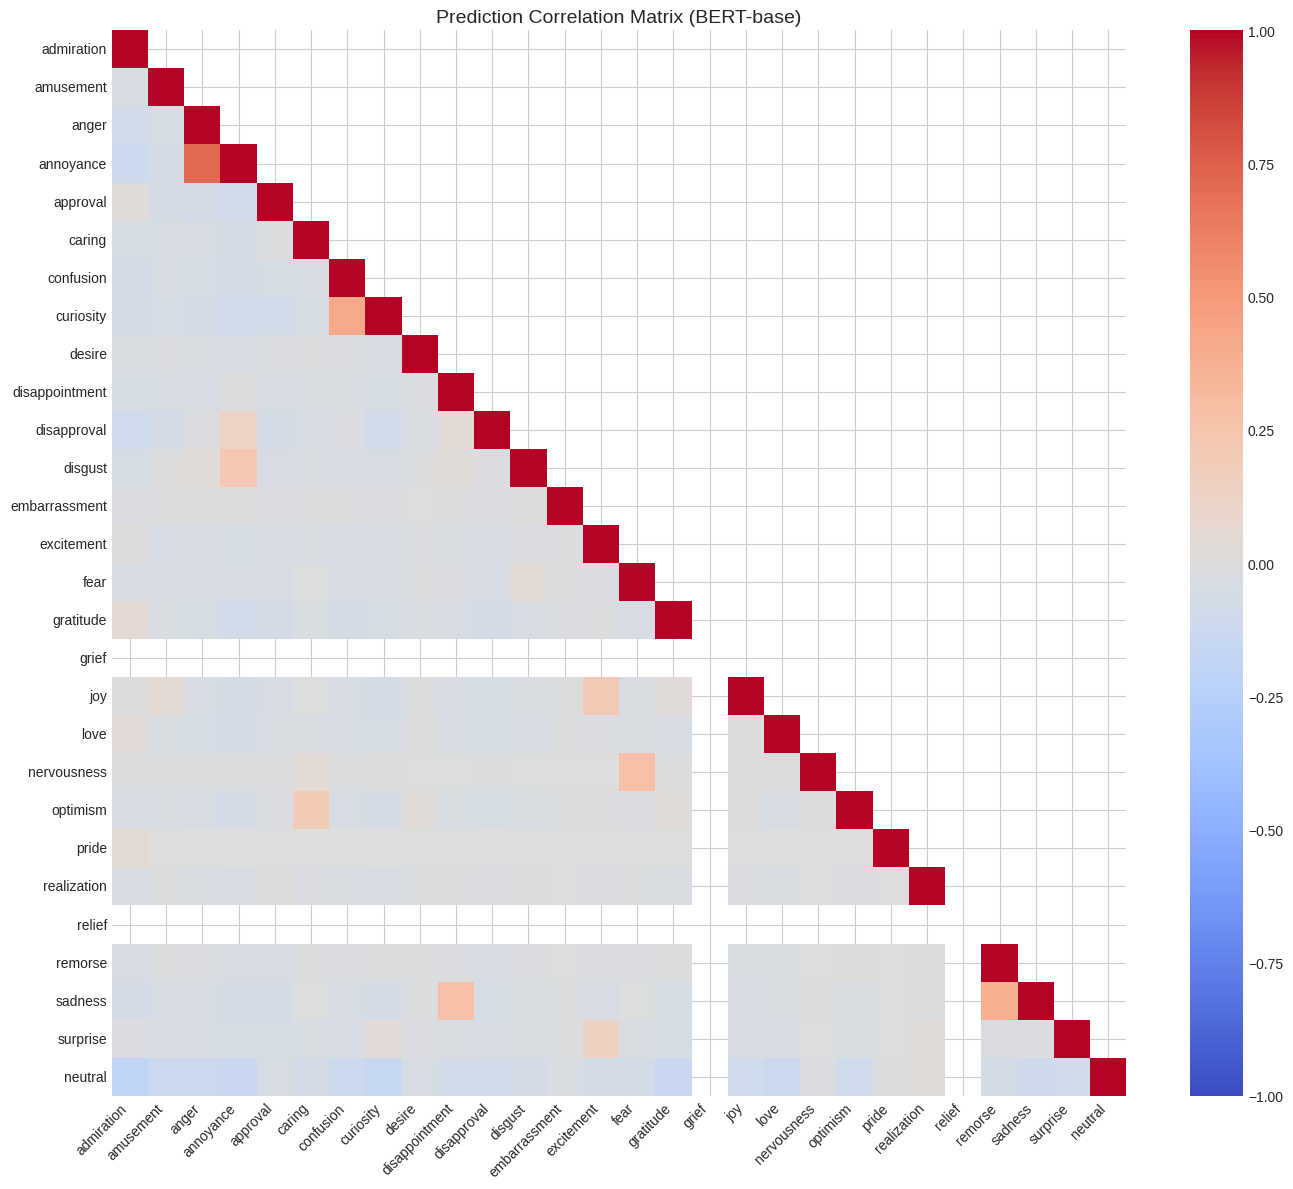

In [28]:
probs = results['bert-base']['probabilities']
preds = (probs > optimal_thresholds['bert-base']['threshold']).astype(int)

pred_corr = np.corrcoef(preds.T)

fig, ax = plt.subplots(figsize=(14, 12))

mask = np.triu(np.ones_like(pred_corr, dtype=bool), k=1)

sns.heatmap(
    pred_corr,
    mask=mask,
    annot=False,
    cmap='coolwarm',
    xticklabels=LABEL_NAMES,
    yticklabels=LABEL_NAMES,
    ax=ax,
    vmin=-1,
    vmax=1,
    center=0
)

ax.set_title('Prediction Correlation Matrix (BERT-base)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'prediction_correlation.png'), dpi=150, bbox_inches='tight')
plt.show()

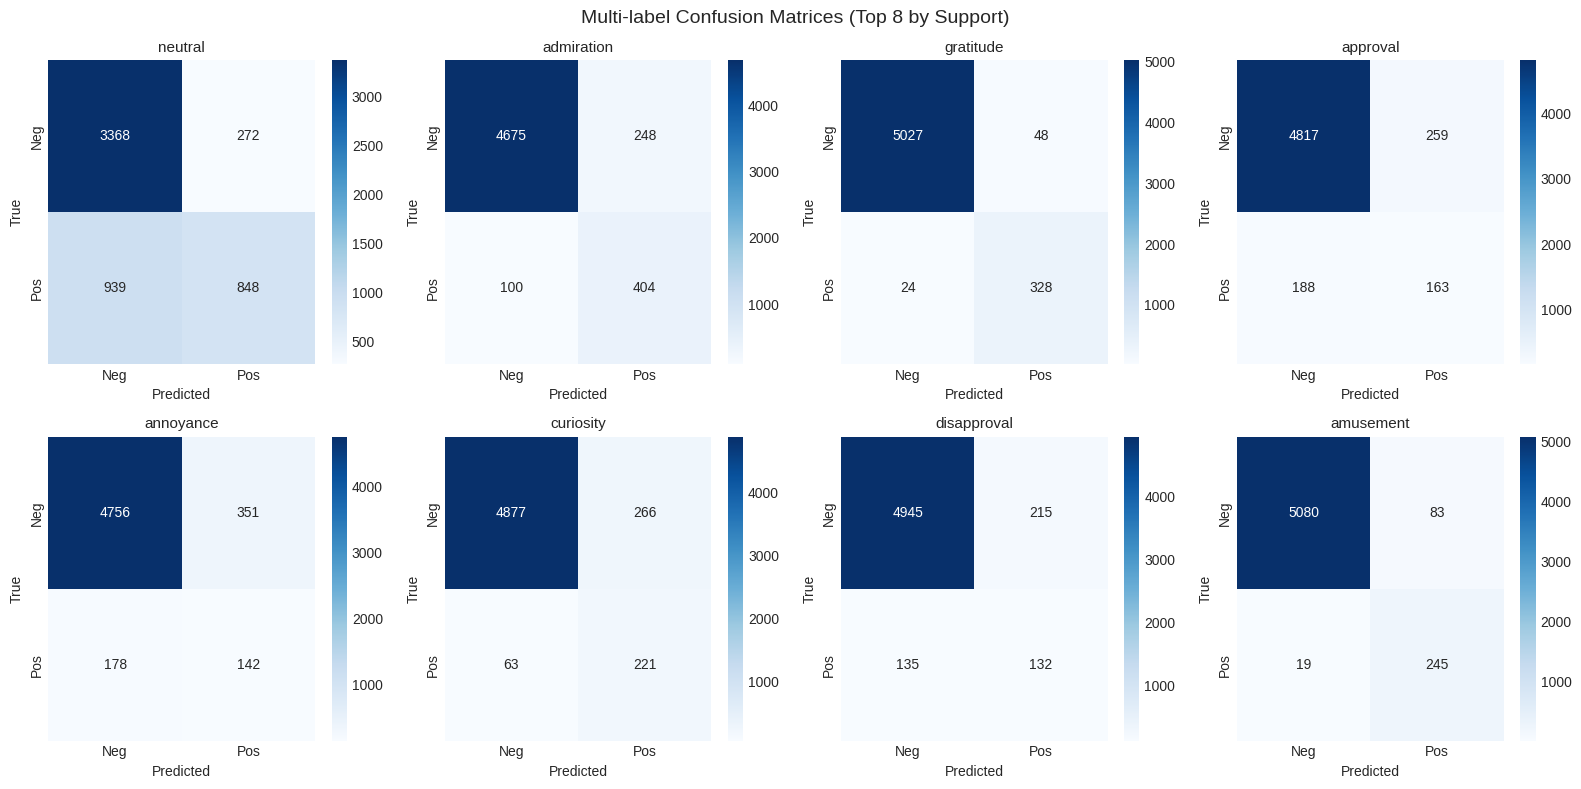

In [29]:
mcm = multilabel_confusion_matrix(true_labels, preds)

top_labels = per_label_df.nlargest(8, 'support')['label'].tolist()
top_indices = [LABEL_NAMES.index(l) for l in top_labels]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for ax, idx, label in zip(axes, top_indices, top_labels):
    cm = mcm[idx]
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Neg', 'Pos'],
        yticklabels=['Neg', 'Pos'],
        ax=ax
    )
    ax.set_title(f'{label}', fontsize=11)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.suptitle('Multi-label Confusion Matrices (Top 8 by Support)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(config.EVAL_DIR, 'multilabel_confusion.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Inference Speed Benchmarking

In [30]:
@torch.no_grad()
def benchmark_inference(model, dataset, num_samples=500, warmup_runs=10, benchmark_runs=50):
    """Benchmark inference speed."""
    model.eval()
    
    sample_data = dataset.select(range(min(num_samples, len(dataset))))
    input_ids = torch.tensor(np.array(sample_data['input_ids'])).to(device)
    attention_mask = torch.tensor(np.array(sample_data['attention_mask'])).to(device)
    
    for _ in range(warmup_runs):
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    times = []
    for _ in range(benchmark_runs):
        start = time.perf_counter()
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        times.append(time.perf_counter() - start)
    
    times = np.array(times)
    
    return {
        'mean_time_ms': times.mean() * 1000,
        'std_time_ms': times.std() * 1000,
        'samples_per_second': num_samples / times.mean(),
        'ms_per_sample': (times.mean() * 1000) / num_samples
    }

print("⏱️ Benchmarking inference speed...")

benchmark_results = {}
for model_name, model in models.items():
    print(f"   Benchmarking {model_name}...")
    benchmark_results[model_name] = benchmark_inference(model, test_dataset)

print("\n✅ Benchmarking complete!")

⏱️ Benchmarking inference speed...
   Benchmarking bert-base...
   Benchmarking distilbert...
   Benchmarking tinybert...

✅ Benchmarking complete!


In [31]:
benchmark_df = pd.DataFrame([
    {
        'Model': name,
        'Samples/sec': f"{res['samples_per_second']:.1f}",
        'ms/sample': f"{res['ms_per_sample']:.3f}",
        'Mean Time (ms)': f"{res['mean_time_ms']:.2f}"
    }
    for name, res in benchmark_results.items()
])

print("\n⏱️ Inference Speed Comparison:")
print(benchmark_df.to_string(index=False))


⏱️ Inference Speed Comparison:
     Model Samples/sec ms/sample Mean Time (ms)
 bert-base       339.3     2.947        1473.42
distilbert       652.3     1.533         766.50
  tinybert      4213.6     0.237         118.66


## 8. Generate Evaluation Report

In [32]:
evaluation_report = {
    'dataset': 'GoEmotions',
    'task': 'Multi-label Emotion Classification',
    'num_labels': NUM_LABELS,
    'label_names': LABEL_NAMES,
    'test_samples': len(test_dataset),
    'models': {}
}

for model_name in results.keys():
    evaluation_report['models'][model_name] = {
        'optimal_threshold': optimal_thresholds[model_name]['threshold'],
        'metrics': all_metrics[model_name],
        'benchmark': benchmark_results[model_name]
    }

report_path = os.path.join(config.EVAL_DIR, 'evaluation_report.json')
with open(report_path, 'w') as f:
    json.dump(evaluation_report, f, indent=2, default=float)

print(f"✅ Report saved to: {report_path}")

✅ Report saved to: ./evaluation/evaluation_report.json


In [33]:
print("\n" + "="*80)
print("📋 GOEMOTIONS EVALUATION SUMMARY")
print("="*80)

print(f"\n📊 Dataset: {evaluation_report['dataset']}")
print(f"📋 Task: {evaluation_report['task']}")
print(f"🏷️ Labels: {evaluation_report['num_labels']}")
print(f"📝 Test Samples: {evaluation_report['test_samples']:,}")

print("\n" + "-"*80)
print("🏆 MODEL COMPARISON")
print("-"*80)

for model_name, data in evaluation_report['models'].items():
    metrics = data['metrics']
    print(f"\n   {model_name.upper()}:")
    print(f"   • Optimal Threshold: {data['optimal_threshold']:.2f}")
    print(f"   • F1 Micro: {metrics['f1_micro']:.4f}")
    print(f"   • F1 Macro: {metrics['f1_macro']:.4f}")
    print(f"   • Hamming Loss: {metrics['hamming_loss']:.4f}")
    print(f"   • Exact Match: {metrics['exact_match']:.4f}")

print("\n" + "="*80)
print("✅ Evaluation Complete!")


📋 GOEMOTIONS EVALUATION SUMMARY

📊 Dataset: GoEmotions
📋 Task: Multi-label Emotion Classification
🏷️ Labels: 28
📝 Test Samples: 5,427

--------------------------------------------------------------------------------
🏆 MODEL COMPARISON
--------------------------------------------------------------------------------

   BERT-BASE:
   • Optimal Threshold: 0.75
   • F1 Micro: 0.5316
   • F1 Macro: 0.4759
   • Hamming Loss: 0.0544
   • Exact Match: 0.2535

   DISTILBERT:
   • Optimal Threshold: 0.70
   • F1 Micro: 0.5310
   • F1 Macro: 0.4699
   • Hamming Loss: 0.0547
   • Exact Match: 0.2464

   TINYBERT:
   • Optimal Threshold: 0.60
   • F1 Micro: 0.4140
   • F1 Macro: 0.2914
   • Hamming Loss: 0.0842
   • Exact Match: 0.1255

✅ Evaluation Complete!
